# Matrix Factorization w/ Alternating Least Square & Weight Regularization (MF-ALS-WR)
Reference: 
* http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import random
import time
from tqdm.notebook import tqdm

## Preprocessing Aid
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer


/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv("source/supporting/goodreads_interactions.csv")

# TESTING MODE
data = data.iloc[0:500000]

In [4]:
## Focus on read and reviewed only i.e., remove is_reviewed == 0 and rating == 0
data = data[(data['is_reviewed']==1)&(data['rating']!=0)]

## Focus on users that have more than 10 book ratings
ratings_per_user = data[(data['is_reviewed']==1)&(data['rating']!=0)].groupby('user_id').size().reset_index(name='number_of_ratings_per_user')
data = data[data.user_id.isin(set(ratings_per_user[ratings_per_user['number_of_ratings_per_user']>=10]['user_id']))]

## Focus on ratings >= 3  
data = data[data.rating>=3]

## Remove is_reviewed and is_read
data = data[['user_id','book_id','rating']]

In [189]:
# Basic statistics about the dataset
print(f"Total number of entries = {len(data)}")
print(f"Total number of unique users = {len(set(data['user_id']))}")
print(f"Total number of unique books = {len(set(data['book_id']))}")

Total number of entries = 31519
Total number of unique users = 398
Total number of unique books = 24542


In [5]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(data.values, test_size=0.2, random_state=17)
train_df = pd.DataFrame(train, columns=data.columns)
test_df = pd.DataFrame(test, columns=data.columns)
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  25215
Test Size :  6304


In [6]:
## Relabel IDs train set for both user and book ids
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['book_id_idx'] = le_item.fit_transform(train_df['book_id'].values)

In [7]:
## Test items that are only present in the train set (i.e., user and book id that are in train set)
test_df = test_df[(test_df['user_id'].isin(train_df['user_id'].unique())) & (test_df['book_id'].isin(train_df['book_id'].unique()))]

## Relabel IDs for test set for both user and book ids
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['book_id_idx'] = le_item.transform(test_df['book_id'].values)

In [8]:
## Preparing for Micorosft's Input -- requires timestamp even though timestamp isn't used
train_df = train_df[['user_id_idx','book_id_idx','rating']]
train_df.rename(columns={"user_id_idx":"userID", "book_id_idx":"itemID"}, inplace =True)
train_df['timestamp'] = 0

test_df = test_df[['user_id_idx','book_id_idx','rating']]
test_df.rename(columns={"user_id_idx":"userID", "book_id_idx":"itemID"}, inplace =True)
test_df['timestamp'] = 0

## Used for downstream processes
combineDF = pd.concat([train_df,test_df])

In [9]:
## Print number of unique users and books after filter
n_users = train_df['userID'].nunique()
n_items = train_df['itemID'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Books : ", n_items)

Number of Unique Users :  398
Number of unique Books :  20177


In [10]:
class ALS_MF():
    def __init__(self, train_df, test, n_factors=40, lambda_=0.1, n_iter=10, K=20):
        self.train_df = train_df
        self.ratings = pd.pivot_table(train_df, values='rating', index=['userID'],columns=['itemID']).fillna(0)
        self.test = test
        self.n_users, self.n_items = self.ratings.shape
        self.n_factors = n_factors
        self.lambda_ = lambda_
        self.n_iter = n_iter
        self.K = K

    def als_step(self, ratings, updateVec, fixVec):
        A = fixVec.T.dot(fixVec) + np.eye(self.n_factors) * self.lambda_
        b = ratings.dot(fixVec)
        A_inv = np.linalg.inv(A)
        updateVec = b.dot(A_inv)
        return updateVec

    def trainANDtest(self):
        self.train_mse_record = []   
        self.recall = []   
        self.precision = []   
        
        self.user_vecs = np.random.normal(size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(size=(self.n_items, self.n_factors))
        for _ in range(self.n_iter):
            self.user_vecs = self.als_step(self.ratings, self.user_vecs, self.item_vecs)
            self.item_vecs = self.als_step(self.ratings.T, self.item_vecs, self.user_vecs) 
            predictions = self.predict_all()
            self.train_mse_record.append(mean_squared_error(self.ratings, predictions))
            recall, precision = self.getMetrics()
            self.recall.append(recall)
            self.precision.append(precision)
        
        self.plot_learning_curve()
        return predictions
    
    def predict_all(self):
        return self.user_vecs.dot(self.item_vecs.T)
        
    def recommendTopKAll(self):
        predictions = self.predict_all()
        predictions[predictions < 0] = int(0) ## set anything less than 0.3 to 0
        predictions = pd.DataFrame(predictions).reset_index()
        predictions = predictions.melt(id_vars=['userID'], value_vars=list(set(predictions.columns)-{"userID"}),\
                                       var_name='itemID', value_name='prediction')
        predictions = predictions[predictions['prediction']!=0]
        predictions = predictions[predictions['userID'].isin(self.test.userID.unique())]
        predictions = predictions.groupby('userID').apply(lambda x: x.nlargest(self.K, 'prediction'))
        predictions = predictions.reset_index(drop=True)
        return predictions
    
    def recommendTopK(self, userID):
        predictions = self.user_vecs.iloc[userID].dot(self.item_vecs.T)
        predictions = predictions.reset_index(name="relevance_score").sort_values('relevance_score', ascending=False)
        predictions = predictions[~predictions.itemID.isin(np.nonzero(self.ratings.iloc[0].values)[0])]
        predictions = predictions.iloc[:self.K].reset_index(drop=True)
        
        interaction_train = self.train_df[self.train_df["userID"]==userID].groupby('userID')['itemID'].apply(list).iloc[0]
        interaction_test = self.test[self.test["userID"]==userID].groupby('userID')['itemID'].apply(list).iloc[0]
        predictions['inTrain'] = predictions.apply(lambda x: True if x.itemID in interaction_train else False, axis=1)
        predictions['inTest'] = predictions.apply(lambda x: True if x.itemID in interaction_test else False, axis=1)
        return predictions    
    
    def getMetrics(self):
        predictionsDF = self.recommendTopKAll()
        predictionsDF = predictionsDF.groupby('userID')['itemID'].apply(list).reset_index()
        predictionsDF.rename(columns={"itemID":"top_rlvnt_itm"}, inplace=True)
        test_interacted_items = self.test.groupby('userID')['itemID'].apply(list).reset_index()
        metrics_df = pd.merge(test_interacted_items,predictionsDF, how= 'left', on = 'userID')
        metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.itemID, metrics_df.top_rlvnt_itm)]
        metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['itemID']), axis = 1) 
        metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/self.K, axis = 1)
        return metrics_df['recall'].mean(), metrics_df['precision'].mean()
    
    def plot_learning_curve(self):
        fig = plt.figure(figsize=(8,8))
        plt.plot(self.train_mse_record, label = 'Train')
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.title(f"MSE for ALS - MF w/ factors={self.n_factors}, lambda={self.lambda_}, and iterations={self.n_iter}")
        plt.legend(loc = 'best')
        plt.show()
        
        fig = plt.figure(figsize=(8,8))
        plt.plot(self.recall, label='Recall')
        plt.plot(self.precision, label='Precision')
        plt.xlabel('n_iter')
        plt.ylabel('Metrics')
        plt.title(f"Recall@{self.K} & Precision@{self.K} for ALS-MF")
        plt.legend(loc = 'best')
        plt.show()
           

In [11]:
K = 20
als_mf = ALS_MF(train_df, test_df, n_factors=36, lambda_=0.01, n_iter=20, K=K)

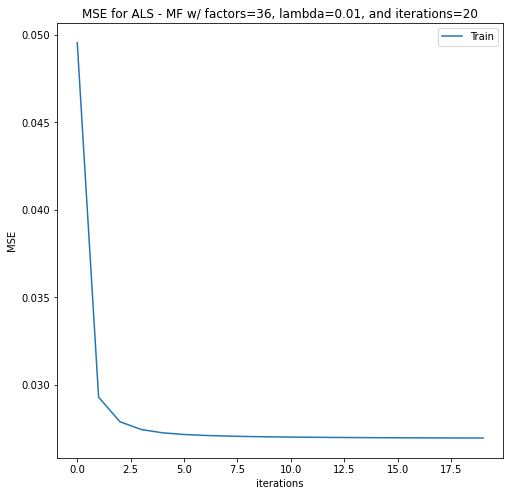

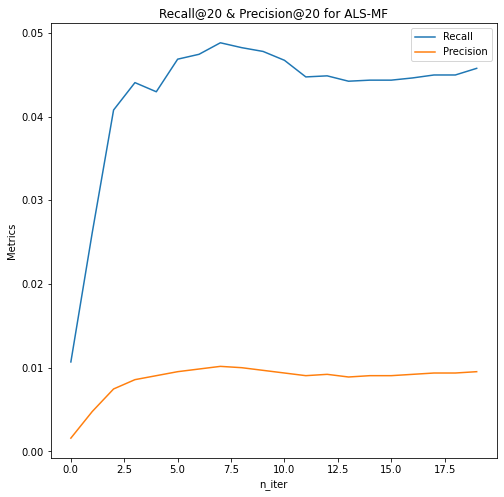

Took 45.1316 seconds for training.


In [12]:
with Timer() as train_time:
    als_mfPred = als_mf.trainANDtest()
print("Took {} seconds for training.".format(train_time))

In [13]:
als_mf.recommendTopK(userID=3)

,itemID,relevance_score,inTrain,inTest
0,595,5.096090,True,False
1,1194,5.048410,True,False
2,785,5.045375,True,False
3,1192,5.013458,True,False
4,1456,5.012570,True,False
5,1457,5.005933,True,False
6,1226,5.002216,True,False
7,1588,4.981640,True,False
8,2605,4.980178,True,False
9,2252,4.980178,True,False


In [201]:
topk_scores = als_mf.recommendTopKAll()
topk_scores = topk_scores.astype({'itemID': 'int64', 'prediction':'float32'})
eval_map = map_at_k(test_df, topk_scores, k=K)
eval_precision = precision_at_k(test_df, topk_scores, k=K)
eval_recall = recall_at_k(test_df, topk_scores, k=K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.013501
Precision@K:	0.009841
Recall@K:	0.045891
